# **Exploratory Data Analysis**

In [76]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go 
from plotly.subplots import make_subplots

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else(x))

1.1. Filtering for Top 3 Data roles in Germany

In [77]:
df_Germany = df[df['job_country'] == 'Germany']
df_Germany['job_title_short'].value_counts().head(3)

job_title_short
Data Analyst      7131
Data Scientist    6745
Data Engineer     6675
Name: count, dtype: int64

In [78]:
# Including only Top 3 Data Jobs in Germany for exploration
df_Data_Germany = df[(df['job_country'] == 'Germany') & (df['job_title_short'].isin(['Data Analyst', 'Data Scientist', 'Data Engineer']))].copy()
df_Data_Germany.head(10)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills,job_type_skills
2,Data Engineer,"Data Engineer/Scientist/Analyst, Mid or Senior...","Berlin, Germany",via LinkedIn,Full-time,False,Germany,2023-10-10 13:14:55,False,False,Germany,None,NaN,NaN,ALPHA Augmented Services,"[python, sql, c#, azure, airflow, dax, docker,...","{'analyst_tools': ['dax'], 'cloud': ['azure'],..."
34,Data Analyst,Data Analyst als Marketing Manager Automation ...,"Erlangen, Germany",via Central Illinois Proud Jobs,Full-time,False,Germany,2023-02-23 13:31:28,True,False,Germany,None,NaN,NaN,DEFACTO GmbH,[sap],{'analyst_tools': ['sap']}
141,Data Analyst,Data Analyst & Process Developer (m/w/d),"Mettlach, Germany",via WTRF Jobs,Full-time,False,Germany,2023-05-02 13:24:54,True,False,Germany,None,NaN,NaN,Villeroy & Boch AG Hauptverwaltung,"[typescript, html, css, javascript, angular, sap]","{'analyst_tools': ['sap'], 'programming': ['ty..."
142,Data Analyst,Data Analyst (m/f/d),"Nuremberg, Germany",via Big Country Jobs,Full-time,False,Germany,2023-01-19 14:05:05,False,False,Germany,None,NaN,NaN,Symanto,"[python, r, sql, azure, power bi, excel, power...","{'analyst_tools': ['power bi', 'excel', 'power..."
175,Data Analyst,German speaking Data Analyst,"Bremen, Germany",via BeBee,Temp work,False,Germany,2023-11-19 13:17:23,False,False,Germany,None,NaN,NaN,Hito High Professionals GmbH,"[sap, excel]","{'analyst_tools': ['sap', 'excel']}"
199,Data Scientist,Data Scientist (f/m/d) | Recommendation,Anywhere,via LinkedIn,Full-time,True,Germany,2023-04-06 13:16:43,False,False,Germany,None,NaN,NaN,eduki,"[go, sql, python, windows]","{'os': ['windows'], 'programming': ['go', 'sql..."
220,Data Analyst,Inhouse Junior Data Analyst,"Berlin, Germany",via BeBee,Full-time,False,Germany,2023-11-21 14:02:06,True,False,Germany,None,NaN,NaN,NEW YORKER Group-Services International GmbH &...,[windows],{'os': ['windows']}
228,Data Engineer,Intern Data Preparation Automation and AI (m/f...,"Munich, Germany",via XING,Internship,False,Germany,2023-10-20 13:18:58,False,False,Germany,None,NaN,NaN,Munich Re,"[python, sql, r, git]","{'other': ['git'], 'programming': ['python', '..."
260,Data Scientist,Data Scientist Technology Risk (w/m/d),"Munich, Germany",via WJHL Jobs,Full-time,False,Germany,2023-03-23 13:18:48,False,False,Germany,None,NaN,NaN,Ernst & Young GmbH,"[excel, powerpoint, outlook, word]","{'analyst_tools': ['excel', 'powerpoint', 'out..."
262,Data Scientist,Data Scientist (m/w/d),"Frankfurt, Germany",via Stepstone,Full-time,False,Germany,2023-08-02 13:45:41,False,False,Germany,None,NaN,NaN,Deutsche Bundesbank,"[python, r, java, sql, azure, aws]","{'cloud': ['azure', 'aws'], 'programming': ['p..."


1.2. Analyzing top locations for Top 3 Data Jobs in Germany

In [79]:
df_Data_Germany['job_location'].value_counts().head(10)

job_location
Berlin, Germany        2685
Munich, Germany        1856
Germany                1792
Hamburg, Germany       1350
Frankfurt, Germany     1022
Anywhere                912
Cologne, Germany        692
Düsseldorf, Germany     641
Stuttgart, Germany      634
Hanover, Germany        316
Name: count, dtype: int64

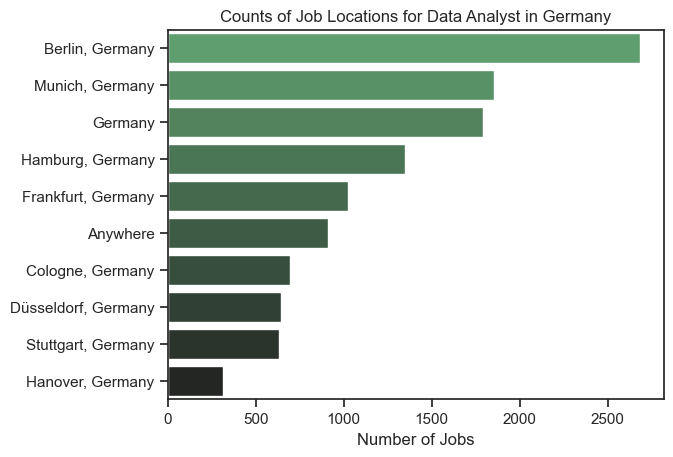

In [80]:
df_location_plot = (df_Data_Germany['job_location']
    .value_counts()
    .head(10)
    .to_frame()
    .reset_index())

sns.set_theme(style='ticks')
sns.barplot(data=df_location_plot, x='count', y='job_location', palette='dark:g_r')
plt.title('Counts of Job Locations for Data Analyst in Germany')
plt.xlabel('Number of Jobs')
plt.ylabel('')
plt.show()

1.3. Cleaning Job Locations

In [81]:
# Checking for exact string "Germany" (not containing Germany)
exact_germany = df_Data_Germany[df_Data_Germany['job_location'] == 'Germany']

# Checking if exact string 'Germany' is associated with remote work and can we re-named as 'Anywhere'
if exact_germany.empty:
    print("No rows with exact 'Germany in job_location")
else:
    all_remote = exact_germany['job_work_from_home'].all()
    
    if all_remote:
        print("✓ All exact 'Germany' rows have work_from_home = True")
    else:
        print("✗ Some 'Germany' rows don't have work_from_home = True")
        print("Problematic rows:")
        print(exact_germany[~exact_germany['job_work_from_home']])

✗ Some 'Germany' rows don't have work_from_home = True
Problematic rows:
       job_title_short                                         job_title   
1725     Data Engineer               Data Engineer SAP Reporting (m/w/d)  \
2177    Data Scientist              Data Scientist Kundendatenauswertung   
2618     Data Engineer                            Remote: Data Engineers   
2904     Data Engineer                             Data Engineer (m/f/d)   
3104    Data Scientist                         Data Warehouse Specialist   
...                ...                                               ...   
781829  Data Scientist  Data Scientist with Focus on Experience Analyses   
783250  Data Scientist                                    Data Scientist   
783636    Data Analyst                                      Data Analyst   
783879  Data Scientist                                    Data Scientist   
785168    Data Analyst              Data Analyst COO Business Management   

       job_loc

1.3. a. Checking the percentage of number of rows containing both location Germany and no remote work status. 

In [82]:
# Creating dataset containing only 'Germany' and is not remote
df_exact_germany_no_remote = df_Data_Germany[(df_Data_Germany['job_location'] == 'Germany') & (df_Data_Germany['job_work_from_home'] == False)]

germany_no_remote_percentage = (len(df_exact_germany_no_remote) / len(df_Data_Germany)) * 100

print(f"Rows with exact 'Germany' and no remote work: {len(df_exact_germany_no_remote):,}")
print(f"Total rows in dataset Germany - Data Jobs: {len(df_Data_Germany)}")
print(f"Percentage of jobs with location Germany and no remote work {germany_no_remote_percentage:.2f}")

Rows with exact 'Germany' and no remote work: 1,792
Total rows in dataset Germany - Data Jobs: 20551
Percentage of jobs with location Germany and no remote work 8.72


1.3.b. Changing the "Germany" location to new name: "Location Uspecified"

In [83]:
df_Data_Germany['location_cleaned'] = df_Data_Germany['job_location'].str.split(',').str[0]

# Updating based on the work from home status
df_Data_Germany.loc[(df_Data_Germany['job_location'] == 'Germany') & df_Data_Germany['job_work_from_home'], 'location_cleaned'] = 'Anywhere'
df_Data_Germany.loc[(df_Data_Germany['job_location'] == 'Germany') & ~df_Data_Germany['job_work_from_home'], 'location_cleaned'] = 'Location Unspecified'
print(df_Data_Germany['location_cleaned'].value_counts().head(10))


location_cleaned
Berlin                  2716
Munich                  1859
Location Unspecified    1792
Hamburg                 1358
Frankfurt               1062
Anywhere                 912
Cologne                  698
Düsseldorf               655
Stuttgart                638
Hanover                  333
Name: count, dtype: int64


In [84]:
df_Data_Germany.head(10)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills,job_type_skills,location_cleaned
2,Data Engineer,"Data Engineer/Scientist/Analyst, Mid or Senior...","Berlin, Germany",via LinkedIn,Full-time,False,Germany,2023-10-10 13:14:55,False,False,Germany,None,NaN,NaN,ALPHA Augmented Services,"[python, sql, c#, azure, airflow, dax, docker,...","{'analyst_tools': ['dax'], 'cloud': ['azure'],...",Berlin
34,Data Analyst,Data Analyst als Marketing Manager Automation ...,"Erlangen, Germany",via Central Illinois Proud Jobs,Full-time,False,Germany,2023-02-23 13:31:28,True,False,Germany,None,NaN,NaN,DEFACTO GmbH,[sap],{'analyst_tools': ['sap']},Erlangen
141,Data Analyst,Data Analyst & Process Developer (m/w/d),"Mettlach, Germany",via WTRF Jobs,Full-time,False,Germany,2023-05-02 13:24:54,True,False,Germany,None,NaN,NaN,Villeroy & Boch AG Hauptverwaltung,"[typescript, html, css, javascript, angular, sap]","{'analyst_tools': ['sap'], 'programming': ['ty...",Mettlach
142,Data Analyst,Data Analyst (m/f/d),"Nuremberg, Germany",via Big Country Jobs,Full-time,False,Germany,2023-01-19 14:05:05,False,False,Germany,None,NaN,NaN,Symanto,"[python, r, sql, azure, power bi, excel, power...","{'analyst_tools': ['power bi', 'excel', 'power...",Nuremberg
175,Data Analyst,German speaking Data Analyst,"Bremen, Germany",via BeBee,Temp work,False,Germany,2023-11-19 13:17:23,False,False,Germany,None,NaN,NaN,Hito High Professionals GmbH,"[sap, excel]","{'analyst_tools': ['sap', 'excel']}",Bremen
199,Data Scientist,Data Scientist (f/m/d) | Recommendation,Anywhere,via LinkedIn,Full-time,True,Germany,2023-04-06 13:16:43,False,False,Germany,None,NaN,NaN,eduki,"[go, sql, python, windows]","{'os': ['windows'], 'programming': ['go', 'sql...",Anywhere
220,Data Analyst,Inhouse Junior Data Analyst,"Berlin, Germany",via BeBee,Full-time,False,Germany,2023-11-21 14:02:06,True,False,Germany,None,NaN,NaN,NEW YORKER Group-Services International GmbH &...,[windows],{'os': ['windows']},Berlin
228,Data Engineer,Intern Data Preparation Automation and AI (m/f...,"Munich, Germany",via XING,Internship,False,Germany,2023-10-20 13:18:58,False,False,Germany,None,NaN,NaN,Munich Re,"[python, sql, r, git]","{'other': ['git'], 'programming': ['python', '...",Munich
260,Data Scientist,Data Scientist Technology Risk (w/m/d),"Munich, Germany",via WJHL Jobs,Full-time,False,Germany,2023-03-23 13:18:48,False,False,Germany,None,NaN,NaN,Ernst & Young GmbH,"[excel, powerpoint, outlook, word]","{'analyst_tools': ['excel', 'powerpoint', 'out...",Munich
262,Data Scientist,Data Scientist (m/w/d),"Frankfurt, Germany",via Stepstone,Full-time,False,Germany,2023-08-02 13:45:41,False,False,Germany,None,NaN,NaN,Deutsche Bundesbank,"[python, r, java, sql, azure, aws]","{'cloud': ['azure', 'aws'], 'programming': ['p...",Frankfurt


1.4. Plotting with cleaned location data

In [85]:
df_location_plot = (df_Data_Germany['location_cleaned']
    .value_counts()
    .head(10)
    .to_frame()
    .reset_index()
    .rename(columns={'location_cleaned': 'City', 'count': 'Job Postings'}))

fig = px.bar(
    df_location_plot,
    x='Job Postings',
    y='City',
    orientation='h',
    title='<b>Top Hiring Locations for Data Jobs in Germany</b>',
    color='Job Postings',
    color_continuous_scale='Greens'
)

# Customizing hover template
fig.update_traces(
    textposition='outside',
    hovertemplate=(
        '<b>%{y}</b><br>' +
        'Job Postings: %{x:,}' +
        '<extra></extra>'
    ),
    texttemplate='%{x:,}'  
)

fig.update_layout(
    yaxis={'categoryorder': 'total ascending', 'title': ''},
    xaxis={'tickformat': ',', 'title': ' '},
    plot_bgcolor='white',
    hovermode='y unified',
    showlegend=False
)

# Adding grid lines
fig.update_xaxes(showgrid=True, gridcolor='lightgrey')

fig.show()

1.5.a. Mapping type of contracts

In [86]:
# Checking the specifics of contracts provided by companies
df_Data_Germany['job_schedule_type'].value_counts()

job_schedule_type
Full-time                                18241
Full-time and Part-time                    650
Part-time                                  630
Internship                                 326
Contractor                                 184
Full-time and Temp work                     90
Full-time and Internship                    86
Temp work                                   72
Part-time and Internship                    40
Full-time, Part-time, and Temp work         23
Pekerjaan tetap                             18
Temp work and Internship                    15
Full-time, Part-time, and Internship        14
Contractor and Temp work                    14
Full-time and Contractor                    13
Part-time and Full-time                     11
Full-time, Temp work, and Internship        10
Part-time and Temp work                      8
Part-time and Contractor                     6
Full-time, Contractor, and Temp work         1
Full-time, Contractor, and Internship     

In [87]:
df_Data_Germany = df_Data_Germany.copy()

# Simplying to 4 main categories contract types
def simplify_schedule_type(schedule):
    if pd.isna(schedule):
        return None
    
    schedule_types = str(schedule).lower()

    if 'full-time' in schedule_types:
        return 'Full-time'

    elif 'part-time' in schedule_types:
        return 'Part-time'

    elif 'internship' in schedule_types:
        return 'Internship'

    elif 'contractor' in schedule_types or 'temp' in schedule_types:
        return 'Contract/Temp'

    else:
        return 'Other'

# Applying schedule type mapping
df_Data_Germany['schedule_simplified'] = df_Data_Germany['job_schedule_type'].apply(simplify_schedule_type)

print("Distribution after simplification:")
print(df_Data_Germany['schedule_simplified'].value_counts())

Distribution after simplification:
schedule_simplified
Full-time        19143
Part-time          685
Internship         342
Contract/Temp      270
Other               18
Name: count, dtype: int64


In [88]:
filtered_df = df_Data_Germany.loc[
    df_Data_Germany['schedule_simplified'] == 'Other',
    ['job_schedule_type', 'schedule_simplified']
]

print(filtered_df)

       job_schedule_type schedule_simplified
784549   Pekerjaan tetap               Other
784552   Pekerjaan tetap               Other
785107   Pekerjaan tetap               Other
785108   Pekerjaan tetap               Other
785354   Pekerjaan tetap               Other
785356   Pekerjaan tetap               Other
785357   Pekerjaan tetap               Other
785359   Pekerjaan tetap               Other
785445   Pekerjaan tetap               Other
785708   Pekerjaan tetap               Other
785714   Pekerjaan tetap               Other
785717   Pekerjaan tetap               Other
785723   Pekerjaan tetap               Other
785724   Pekerjaan tetap               Other
785725   Pekerjaan tetap               Other
785729   Pekerjaan tetap               Other
785732   Pekerjaan tetap               Other
785737   Pekerjaan tetap               Other


In [89]:
# Dropping 'Other' for type of contracts in Germany since it feels like a mistake
df_Data_Germany = df_Data_Germany[df_Data_Germany['schedule_simplified'] != 'Other']

1.5.b. Plotting type of contracts in Germany

In [90]:
# Creating visualization for job contract types
df_viz = (
    df_Data_Germany['schedule_simplified']
    .value_counts()
    .reset_index()
    .rename(columns={'count': 'Job Count', 'schedule_simplified': 'Contract Type'})
)

fig = px.pie(df_viz,
            values='Job Count',
            names='Contract Type',
            title='<b>Distribution of Job Contract Types in Germany</b>',
            color_discrete_sequence=px.colors.qualitative.Set3,
            hover_data={'Job Count': ':,'}
)

fig.update_traces(
    textposition='outside',
    textinfo='percent+label',
    texttemplate='%{label}<br>%{percent:.1%}',
    rotation=60,
    hovertemplate=(
        '<b>%{label}</b><br>' +
        'Jobs: %{value:,}<br>' +
        'Share: %{percent:.1%}' +
        '<extra></extra>'
    ),
    marker=dict(line=dict(color='white', width=1))
)

fig.update_layout(
    hovermode='closest',
    legend=dict(
        title='<b>Contract Type</b>',
        yanchor="top",
        y=0.95,
        xanchor="left",
        x=1.05
    ),
    uniformtext=dict(minsize=10, mode='hide'),
    margin=dict(t=120, b=50, l=50, r=200),
        title=dict(
        y=0.95,
        x=0.5,
        xanchor='center',
        yanchor='top'
    )
)

fig.show()

1.6.a. Investigating how many job offers are being provided with potential salaries

In [91]:
salary_nan = df_Data_Germany['salary_year_avg'].isna().sum()
print(f"Total rows: {len(df_Data_Germany)}")
print(f"Null values: {salary_nan}")

Total rows: 20533
Null values: 20405


In [92]:
# Adding new column to specify if the salary is shown in the job offer or not
df_Data_Germany['salary_mentioned'] = df_Data_Germany['salary_year_avg'].apply(lambda x: pd.notna(x))
df_Data_Germany['salary_mentioned'].value_counts()

salary_mentioned
False    20405
True       128
Name: count, dtype: int64

In [93]:
# Confirming the column was added
print(df_Data_Germany.columns.tolist())

['job_title_short', 'job_title', 'job_location', 'job_via', 'job_schedule_type', 'job_work_from_home', 'search_location', 'job_posted_date', 'job_no_degree_mention', 'job_health_insurance', 'job_country', 'salary_rate', 'salary_year_avg', 'salary_hour_avg', 'company_name', 'job_skills', 'job_type_skills', 'location_cleaned', 'schedule_simplified', 'salary_mentioned']


1.6.b. Plotting 3 key characteristics for job positions in Germany Data Market

In [94]:
dict_column = {
    'job_work_from_home': 'Work From Home',
    'job_no_degree_mention': 'Job Degree Required',
    'salary_mentioned': 'Salary Specified'
}

fig = make_subplots(
    rows=1,
    cols=3,
    specs=[[{'type': 'pie'}, {'type': 'pie'}, {'type': 'pie'}]],
    subplot_titles=[f"{title}" for title in dict_column.values()],
    vertical_spacing=0.9
)

for i, (column, title) in enumerate(dict_column.items(), 1):
    value_counts = df_Data_Germany[column].value_counts()

    fig.add_trace(
        go.Pie(
            labels=['No', 'Yes'],
            values=value_counts.values,
            hole=0.4,
            textinfo='percent+label',
            texttemplate='%{label}<br>%{percent:.1%}',
            textposition='outside',
            marker=dict(
                colors=['#FF6B6B', '#4ECDC4'],
                line=dict(color='white', width=2)
            ),
            pull=[0.05, 0],
            rotation=120,
            hovertemplate=(
                '<b>%{label} - ' + title + '</b><br>' +
                '%{value:,} jobs (%{percent:.1%})' +
                '<extra></extra>'
            )
        ),
        row=1, col=i
    )

fig.update_annotations(
    dict(
        font=dict(
            size=16,
            family="Arial Black",
            color="#2E86AB"
        ),
        y=1.07 
    )
)

fig.show()

1.7. Exploring companies with highest hiring potential for Data Professionals in Germany

In [95]:
df_company_plot = (df_Data_Germany['company_name']
    .value_counts()
    .head(10)
    .to_frame()
    .reset_index()
    .rename(columns={'company_name': 'Company', 'count': 'Job Postings'}))

fig = px.bar(
    df_company_plot,
    x='Job Postings',
    y='Company',
    orientation='h',
    title= 'Top 10 Companies Hiring Data Professionals in Germany',
    color='Job Postings',
    color_continuous_scale='bluyl',
    text='Job Postings'
)

fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},
    xaxis_title='',
    yaxis_title='',
)

fig.update_traces(
    textposition='outside',
    textfont=dict(size=12),
       hovertemplate=(
        '<b>%{y}</b><br>' +  
        'Job Postings: %{x:,}' +  
        '<extra></extra>'  
    )
)

fig.show()